<a href="https://colab.research.google.com/github/YanovaAdia/watsonnli_notebook/blob/main/watsonnli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instal library and import package

In [1]:
!pip install -q transformers accelerate datasets evaluate wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 571.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarr

In [2]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments

### Data Preparation

In [3]:
train = pd.read_csv('*******/watsonnli/train.csv')
test = pd.read_csv('********/watsonnli/test.csv')

In [ ]:
train.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'], dtype='object')

In [ ]:
test.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language'], dtype='object')

No imbalance class detected

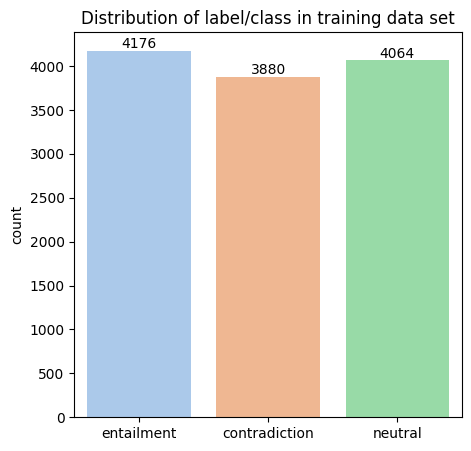

In [41]:

LABEL_NAME = ('entailment', 'contradiction', 'neutral')
f, ax = plt.subplots(figsize=(5,5))
ax = sns.countplot(x=train['label'], hue=train['label'], palette='pastel', legend=False)
ax.set_xticks([0,1,2])
ax.set_xticklabels(LABEL_NAME)
ax.set(xlabel=None, title='Distribution of label/class in training data set')
for container in ax.containers:
    ax.bar_label(container)

Proportion of each language

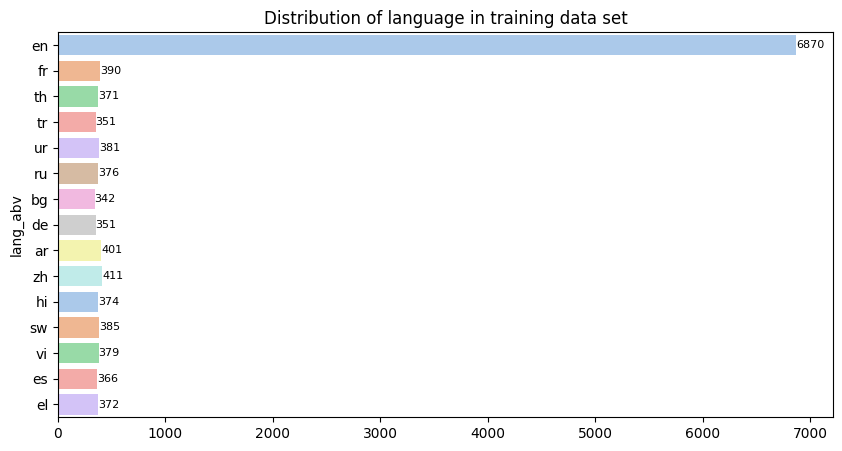

In [45]:
LABEL_NAME = ('entailment', 'contradiction', 'neutral')
f, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(y=train['lang_abv'], hue=train['lang_abv'], palette='pastel', legend=False)
ax.set(xlabel=None, title='Distribution of language in training data set')
for container in ax.containers:
    ax.bar_label(container, size=8)

In [4]:
train = train[['premise', 'hypothesis', 'label']]
test = test[['premise', 'hypothesis']]

In [5]:
from datasets import Dataset, load_metric
train_data = Dataset.from_pandas(train)
test_data = Dataset.from_pandas(test)

In [6]:
train_data

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 12120
})

In [7]:
test_data

Dataset({
    features: ['premise', 'hypothesis'],
    num_rows: 5195
})

In [8]:
split = train_data.train_test_split(test_size=0.2, seed=123)
train_data , val_data = split['train'], split['test']

In [18]:
train_data

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 9696
})

In [19]:
val_data

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 2424
})

### Model Preparation

In [6]:


model_name1 = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
model1 = AutoModelForSequenceClassification.from_pretrained(model_name1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [10]:
model1

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [9]:
tokenized_train = train_data.map(lambda examples: tokenizer1(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length'),batched=True)
tokenized_val = val_data.map(lambda examples: tokenizer1(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length'),batched=True
)

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

In [10]:

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:


batch_size = 8

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/watsonnli/',
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to='wandb',
    lr_scheduler_type="linear",
    logging_strategy='epoch',
)


In [12]:
optimizer = torch.optim.AdamW(
    model1.parameters(),
    lr=training_args.learning_rate,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=training_args.weight_decay,
)

In [13]:
tokenized_train

Dataset({
    features: ['premise', 'hypothesis', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9696
})

In [14]:
from transformers import get_linear_schedule_with_warmup
num_training_steps = len(tokenized_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=50,
    num_training_steps=num_training_steps
)

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer1)

In [16]:
from transformers import Trainer
trainer = Trainer(
    model=model1,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    optimizers=(optimizer, lr_scheduler),
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Model Training

In [17]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.661800,0.641477,0.751238
2,0.490400,0.666942,0.781353


Epoch,Training Loss,Validation Loss,Accuracy
1,0.661800,0.641477,0.751238
2,0.490400,0.666942,0.781353
3,0.311900,0.953865,0.789191
4,0.163200,1.115947,0.800330
5,0.063900,1.317301,0.809818


TrainOutput(global_step=6060, training_loss=0.33824923927634465, metrics={'train_runtime': 7411.1431, 'train_samples_per_second': 6.542, 'train_steps_per_second': 0.818, 'total_flos': 1.27559672487936e+16, 'train_loss': 0.33824923927634465, 'epoch': 5.0})

### Model Evaluation

In [18]:
trainer.save_model('*****/watsonnli/')

In [20]:
tokenized_test = test_data.map(
    lambda examples: tokenizer1(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length'),
    batched=True
)

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

In [22]:
predictions = trainer.predict(tokenized_test)

In [23]:
predicted_labels = predictions.predictions.argmax(axis=-1)

In [25]:
predictions

PredictionOutput(predictions=array([[-0.62881106,  0.16518447,  0.345848  ],
       [-2.0283568 ,  2.6715968 , -0.4680949 ],
       [ 2.07848   , -1.0349181 , -1.3094859 ],
       ...,
       [-0.07885031,  1.1037834 , -1.0913376 ],
       [ 1.9518764 , -1.2532021 , -0.9895392 ],
       [-1.9104347 , -0.29532772,  2.395013  ]], dtype=float32), label_ids=None, metrics={'test_runtime': 237.8721, 'test_samples_per_second': 21.839, 'test_steps_per_second': 2.733})

In [26]:
test_ids = pd.read_csv('******/test.csv')
test_ids = test_ids['id']

In [27]:
results_df = pd.DataFrame({
    'id': test_ids,  # Ensure 'id' or a similar identifier is in your test DataFrame
    'prediction': predicted_labels
})

In [29]:
results_df.head(5)

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [28]:
results_df.to_csv('submission.csv', index=False)